# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Времена предсказания и обучения существенны в задаче,   
но из-за нестабильности сервера python Яндекса время обучения сильно колебалось , особенно вечерами,   
поэтому работа выполнена на домашнем PC  

## Подготовка данных

In [1]:
import numpy as np
import re
from datetime import datetime as dt
import timeit as ti
import pandas as pd
import warnings

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer

In [3]:
import lightgbm as lgb

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as plc

In [5]:
np.random.seed(499)
rmse = lambda y,a: mse(y,a,squared=False)
df = pd.read_csv("/datasets/autos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Я приведу имена колонок к snake_case, так как привык к этому формату

In [6]:
df.columns  = df.columns.map( lambda string: re.sub(r'(.)([A-Z])',r'\1_\2', string ).lower())
nan_cols = [ c for c in df.columns if df[c].isna().sum()>0 ]
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим  колонки с NaN

In [7]:
for c in nan_cols:
    print(f"---- {c} ----- {df[c].isna().sum()} nulls ---- {round(df[c].isna().sum()/df[c].count()*100,1)}% ")
    print(df[c].value_counts().head(10))

---- vehicle_type ----- 37490 nulls ---- 11.8% 
vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64
---- gearbox ----- 19833 nulls ---- 5.9% 
gearbox
manual    268251
auto       66285
Name: count, dtype: int64
---- model ----- 19705 nulls ---- 5.9% 
model
golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: count, dtype: int64
---- fuel_type ----- 32895 nulls ---- 10.2% 
fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64
---- repaired ----- 71154 nulls ---- 25.1% 
repaired
no     247161
yes     36054
Name: count, dtype: int64


Все эти колонки категориальные и пустых значений немного, поэтому их можно заменить на other ,   
тем более что в большинстве этих колонок такое значение уже есть 

In [8]:
df[nan_cols] = df[nan_cols].fillna('other')


Почему-то в этой колонке только нули, во всяком случае в таком виде она бесполезна

In [9]:
df = df.drop('number_of_pictures',axis= 1)  

Выделим колонки, где значения уникальны или почти уникальны и посмотрим дубликаты по оставшимся колонкам

In [10]:
uniq_cols = [ c for c in df.columns if df[c].value_counts().iloc[0]<100 ]  
non_uniq_cols =  [ c for c in df.columns if df[c].value_counts().iloc[0]>=100 ]
for c in df.columns:
    print(c,df[c].value_counts().count(),df[c].value_counts().median())

date_crawled 271174 1.0
price 3731 2.0
vehicle_type 8 34776.5
registration_year 151 8.0
gearbox 3 66285.0
power 712 5.0
model 250 369.0
kilometer 13 7444.0
registration_month 13 26099.0
fuel_type 7 5310.0
brand 40 3112.0
repaired 3 71154.0
date_created 109 9.0
postal_code 8143 26.0
last_seen 179150 1.0


In [11]:
df[df[non_uniq_cols].duplicated(keep=False)].sort_values(by=non_uniq_cols )

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
199835,2016-03-12 11:56:50,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,other,2016-03-12 00:00:00,8301,2016-03-13 03:16:04
283241,2016-03-12 12:41:54,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,other,2016-03-12 00:00:00,8301,2016-03-13 03:45:29
82258,2016-03-17 07:55:14,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,other,2016-03-17 00:00:00,47533,2016-03-22 13:49:41
254668,2016-03-17 09:40:08,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,other,2016-03-17 00:00:00,47533,2016-03-22 15:46:36
50342,2016-03-16 08:55:14,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no,2016-03-16 00:00:00,9235,2016-03-16 08:55:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95559,2016-03-28 20:25:38,20000,sedan,2011,auto,265,c_klasse,50000,11,gasoline,mercedes_benz,no,2016-03-28 00:00:00,60311,2016-03-28 20:25:38
56552,2016-04-04 16:25:17,20000,sedan,2011,auto,265,c_klasse,50000,11,gasoline,mercedes_benz,no,2016-04-04 00:00:00,60311,2016-04-04 16:25:17
115867,2016-04-04 21:25:20,20000,sedan,2011,auto,265,c_klasse,50000,11,gasoline,mercedes_benz,no,2016-04-04 00:00:00,60311,2016-04-04 21:49:06
142818,2016-03-30 13:17:57,20000,suv,2011,manual,150,tiguan,80000,5,petrol,volkswagen,no,2016-03-29 00:00:00,65931,2016-04-05 13:15:54


Похоже это действительно дубликаты с разными датами попадания в базу, я решил удалить их 

In [12]:
df = df.drop_duplicates(subset=non_uniq_cols)

Колонки с датой важны для обучения, по ним определяется время нахожедения в продаже.  
Проще всего их преобразовать в количество секунд.  

In [13]:
date_cols = ['date_crawled','date_created','last_seen']
seconds = lambda s: (dt.strptime(s,'%Y-%m-%d %H:%M:%S')-dt.strptime('1970','%Y')).total_seconds()
df[date_cols] = df[date_cols].apply(lambda r: list(map(seconds,r)) , result_type='expand')
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,1.458820e+09,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other,1.458778e+09,70435,1.459999e+09
1,1.458817e+09,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,1.458778e+09,66954,1.459994e+09
2,1.457960e+09,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,1.457914e+09,90480,1.459860e+09
3,1.458234e+09,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,1.458173e+09,91074,1.458236e+09
4,1.459445e+09,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,1.459382e+09,60437,1.459938e+09


Проверим ещё корреляцию

In [14]:
df.corr(numeric_only=True)

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,postal_code,last_seen
date_crawled,1.000000,0.014872,-0.000144,0.002812,-0.003111,-0.004176,0.974882,0.014038,0.587599
price,0.014872,1.000000,0.026480,0.157173,-0.331086,0.110578,0.010933,0.078113,0.150169
registration_year,-0.000144,0.026480,1.000000,-0.000805,-0.052860,-0.011408,-0.000089,-0.003274,-0.000533
power,0.002812,0.157173,-0.000805,1.000000,0.024047,0.043319,0.002541,0.021839,0.021578
kilometer,-0.003111,-0.331086,-0.052860,0.024047,1.000000,0.010619,-0.000939,-0.008848,-0.065049
registration_month,-0.004176,0.110578,-0.011408,0.043319,0.010619,1.000000,-0.003760,0.014278,-0.001120
date_created,0.974882,0.010933,-0.000089,0.002541,-0.000939,-0.003760,1.000000,0.013253,0.570373
postal_code,0.014038,0.078113,-0.003274,0.021839,-0.008848,0.014278,0.013253,1.000000,0.042399
last_seen,0.587599,0.150169,-0.000533,0.021578,-0.065049,-0.001120,0.570373,0.042399,1.000000


Очень большая корреляция между date_crawled и date_created, одну из них надо удалить 

In [15]:
df = df.drop('date_created',axis= 1)  

## Обучение моделей

Определим колонки признаков и цели 

In [16]:
cat_cols = [ c for c in df.columns if df.dtypes[c] == 'object'  ] 
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int64','float' ] ]
target='price'
features = [c for c in num_cols+cat_cols if c != 'price' ]
features

['date_crawled',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'postal_code',
 'last_seen',
 'vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired']

и скопириуем в датафреймы  

In [17]:
for c in cat_cols:
    df[c] = df[c].astype('category')

X = df[features].copy()
y = df[target].copy()

Затем разделим на тренировочный и тестовый наборы с шаффлингом

In [18]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size = .25,shuffle=True)

Для исследования обучения и предсказания используется кроссвалидация по тренировочному набору  
Будут проверены все четыре алгоритма , используемые в LightGBM  
Так как их нужно запускать с немного разным набором параметров,
 решетка по каждому алгоримту считается отдельно   
В первую очередь я ищу оптимальное количество оценщиков и скорость обучения 

Для большинства тестов наблюдалось постепенное улучшение метрики при приемлимых временах обучения/предсказания, пока число оценшиков не превысило 500. Так как мне хотелось найти какой-то объективный экстремум, я прогонял тесты вплоть до n_estimators = 1024. При этом время обучения оставалось еще приемлимым, хотя вся поисковая решетка проходила тест больше чем за час.  
<font color="darkblue">Время выполнения оставшейся части блокнота составляет несколько часов</color>

Для ускорения расчет расчет проводится на субсэмплах   
Я считаю, что метрика получится несколько хуже, чем на полном наборе,  
но эта дополнительная ошибка буде более-менее равномерной для разных алгоритмов и гиперпараметров,  
так что можно будет выбрать лучший вариант и провести на нём финальное тестирование

### RandomForest   
Как я понимаю, это обычный RandomForest , без градиента  
Ячейка выполняется за ~30 минут

In [19]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['rf'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_rf = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_rf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_rf.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's l2: 3.97886e+06
[CV 1/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1977.480, test=-2045.523) total time=   1.7s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 3.97737e+06
[CV 2/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1977.210, test=-2044.844) total time=   1.7s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not 

[CV 1/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1962.479, test=-2030.359) total time=   5.6s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.94726e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 2/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1962.649, test=-2029.925) total time=   4.9s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.911e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 3/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1964.712, test=-2004.324) total time=   4

[50]	valid_0's l2: 3.94726e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 2/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1962.649, test=-2029.925) total time=   4.9s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.911e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 3/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1964.712, test=-2004.324) total time=   4.4s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.93251e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 4/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l

[50]	valid_0's l2: 3.911e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 3/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1964.712, test=-2004.324) total time=   4.7s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.93251e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 4/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1963.637, test=-2011.283) total time=   4.4s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.94615e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 1/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l

[50]	valid_0's l2: 3.93251e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 4/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1963.637, test=-2011.283) total time=   4.6s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.94615e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 1/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1962.479, test=-2030.359) total time=   4.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.94726e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 2/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=256, num_leaves=511, object

[50]	valid_0's l2: 3.94615e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 1/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1962.479, test=-2030.359) total time=   4.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.94726e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 2/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1962.649, test=-2029.925) total time=   4.7s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.911e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 3/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objectiv

[50]	valid_0's l2: 3.94726e+06
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 2/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1966.859, test=-2034.778) total time=   2.8s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.911e+06
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 3/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1966.262, test=-2005.642) total time=   2.8s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.93251e+06
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 4/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_est

Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 3/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1976.865, test=-2015.964) total time=   1.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 4/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1980.653, test=-2024.265) total time=   1.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.94615e+06
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 1/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, su

[50]	valid_0's l2: 3.93251e+06
Early stopping, best iteration is:
[88]	valid_0's l2: 3.8994e+06
[CV 4/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1963.637, test=-2011.283) total time=   4.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	training's l2: 3.83135e+06
[100]	training's l2: 3.80666e+06
[150]	training's l2: 3.79542e+06
[200]	training's l2: 3.79045e+06
[250]	training's l2: 3.78794e+06
Did not meet early stopping. Best iteration is:
[256]	training's l2: 3.78721e+06
CPU times: total: 43min 3s
Wall time: 13min 4s


{'boosting': 'rf',
 'learning_rate': 0.3,
 'max_depth': 32,
 'n_estimators': 256,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Gradient Boosting Machine
Дефолтный алгоритм   
<font color="darkblue">Ячейка выполняется за ~90 минут </font>

In [20]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['gbdt'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_def = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_def.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_def.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.72854e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1558.872, test=-1903.659) total time=   1.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.71089e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1560.210, test=-1881.700) total time=   1.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.69438e+06
[CV 3/4] END boosting

[50]	valid_0's l2: 2.55158e+06
[100]	valid_0's l2: 2.32333e+06
[150]	valid_0's l2: 2.15871e+06
[200]	valid_0's l2: 2.04559e+06
[250]	valid_0's l2: 1.95292e+06
[300]	valid_0's l2: 1.88413e+06
[350]	valid_0's l2: 1.82676e+06
[400]	valid_0's l2: 1.78346e+06
[450]	valid_0's l2: 1.73858e+06
[500]	valid_0's l2: 1.70428e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's l2: 1.69635e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-696.356, test=-2308.829) total time=  25.4s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.58204e+06
[100]	valid_0's l2: 2.34036e+06
[150]	valid_0's l2: 2.16602e+06
[200]	valid_0's l2: 2.05821e+06
[250]	valid_0's l2: 1.96453e+06
[300]	valid_0's l2: 1.89003e+06
[350]	valid_0's l2: 1.8257e+06
[400]	valid_0's l2: 1.77907e+06
[450]	valid_0's l2: 1.73379e+06
[500]

[CV 1/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1248.329, test=-1889.103) total time=   6.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.47074e+06
[100]	valid_0's l2: 2.1693e+06
Did not meet early stopping. Best iteration is:
[1023]	valid_0's l2: 1.52993e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1248.193, test=-1876.627) total time=   6.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.47753e+06
[100]	valid_0's l2: 2.17349e+06
Did not meet early stopping. Best iteration is:
[1023]	valid_0's l2: 1.52993e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=5

[50]	valid_0's l2: 2.47753e+06
[100]	valid_0's l2: 2.17349e+06
[150]	valid_0's l2: 1.97906e+06
[200]	valid_0's l2: 1.82851e+06
[250]	valid_0's l2: 1.71927e+06
[300]	valid_0's l2: 1.63094e+06
[350]	valid_0's l2: 1.55438e+06
[400]	valid_0's l2: 1.49426e+06
[450]	valid_0's l2: 1.44364e+06
[500]	valid_0's l2: 1.40246e+06
[550]	valid_0's l2: 1.3649e+06
[600]	valid_0's l2: 1.33308e+06
[650]	valid_0's l2: 1.30551e+06
[700]	valid_0's l2: 1.27981e+06
[750]	valid_0's l2: 1.25989e+06
[800]	valid_0's l2: 1.2414e+06
[850]	valid_0's l2: 1.22666e+06
[900]	valid_0's l2: 1.21293e+06
[950]	valid_0's l2: 1.20195e+06
[1000]	valid_0's l2: 1.18962e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.17137e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-397.173, test=-2065.395) total time=  53.2s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored.

[50]	valid_0's l2: 2.58515e+06
[100]	valid_0's l2: 2.26417e+06
[150]	valid_0's l2: 2.05319e+06
[200]	valid_0's l2: 1.9002e+06
[250]	valid_0's l2: 1.77457e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.17137e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1144.739, test=-1765.387) total time=  12.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.58438e+06
[100]	valid_0's l2: 2.24519e+06
[150]	valid_0's l2: 2.04029e+06
[200]	valid_0's l2: 1.88848e+06
[250]	valid_0's l2: 1.76811e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.17137e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1138.749, test=-1768.920) total time=  12.5s
[LightG

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1973.201, test=-2051.292) total time=   1.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1973.366, test=-2027.771) total time=   2.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_

[50]	valid_0's l2: 3.04624e+06
[100]	valid_0's l2: 2.50686e+06
[150]	valid_0's l2: 2.301e+06
[200]	valid_0's l2: 2.15503e+06
[250]	valid_0's l2: 2.03037e+06
[300]	valid_0's l2: 1.92771e+06
[350]	valid_0's l2: 1.83942e+06
[400]	valid_0's l2: 1.76266e+06
[450]	valid_0's l2: 1.69502e+06
[500]	valid_0's l2: 1.63529e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1089.320, test=-1711.606) total time=  25.4s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 3.05842e+06
[100]	valid_0's l2: 2.50649e+06
[150]	valid_0's l2: 2.29471e+06
[200]	valid_0's l2: 2.1438e+06
[250]	valid_0's l2: 2.02861e+06
[300]	valid_0's l2: 1.92856e+06
[350]	valid_0's l2: 1.84075e+06
[400]	valid_0's l2: 1.76393e+06
[450]	valid_0's l2: 1.6945e+06
[500]

[50]	valid_0's l2: 4.15527e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1850.068, test=-1930.782) total time=   2.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 4.1561e+06
[100]	valid_0's l2: 2.8418e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1581.689, test=-1760.046) total time=   6.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 4.15434e+06
[100]	valid_0's l2: 2.83385e+06
Did not meet early stopping. Best iteration is:
[1024]	valid

[50]	valid_0's l2: 4.15434e+06
[100]	valid_0's l2: 2.83385e+06
[150]	valid_0's l2: 2.54223e+06
[200]	valid_0's l2: 2.38972e+06
[250]	valid_0's l2: 2.27198e+06
[300]	valid_0's l2: 2.17423e+06
[350]	valid_0's l2: 2.08889e+06
[400]	valid_0's l2: 2.01373e+06
[450]	valid_0's l2: 1.94769e+06
[500]	valid_0's l2: 1.88747e+06
[550]	valid_0's l2: 1.8325e+06
[600]	valid_0's l2: 1.78171e+06
[650]	valid_0's l2: 1.73724e+06
[700]	valid_0's l2: 1.69517e+06
[750]	valid_0's l2: 1.65444e+06
[800]	valid_0's l2: 1.6156e+06
[850]	valid_0's l2: 1.58055e+06
[900]	valid_0's l2: 1.54825e+06
[950]	valid_0's l2: 1.51797e+06
[1000]	valid_0's l2: 1.48802e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1000.995, test=-1700.832) total time=  55.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignore

[100]	valid_0's l2: 3.39867e+06
[150]	valid_0's l2: 2.82668e+06
[200]	valid_0's l2: 2.59979e+06
[250]	valid_0's l2: 2.46633e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1508.752, test=-1728.607) total time=  12.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 5.86491e+06
[100]	valid_0's l2: 3.39909e+06
[150]	valid_0's l2: 2.8154e+06
[200]	valid_0's l2: 2.58982e+06
[250]	valid_0's l2: 2.45851e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1511.005, test=-1712.961) total time=  12.1s
[LightGBM] [Warning] boosting is set

[200]	valid_0's l2: 2.59104e+06
[250]	valid_0's l2: 2.45991e+06
[300]	valid_0's l2: 2.36254e+06
[350]	valid_0's l2: 2.28035e+06
[400]	valid_0's l2: 2.20963e+06
[450]	valid_0's l2: 2.14544e+06
[500]	valid_0's l2: 2.08884e+06
[550]	valid_0's l2: 2.03494e+06
[600]	valid_0's l2: 1.985e+06
[650]	valid_0's l2: 1.94045e+06
[700]	valid_0's l2: 1.89926e+06
[750]	valid_0's l2: 1.85888e+06
[800]	valid_0's l2: 1.82219e+06
[850]	valid_0's l2: 1.78628e+06
[900]	valid_0's l2: 1.75308e+06
[950]	valid_0's l2: 1.72138e+06
[1000]	valid_0's l2: 1.69075e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1136.337, test=-1683.215) total time=  57.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0'

[50]	valid_0's l2: 9.98154e+06
[100]	valid_0's l2: 5.8675e+06
[150]	valid_0's l2: 4.14794e+06
[200]	valid_0's l2: 3.38878e+06
[250]	valid_0's l2: 3.01147e+06
[300]	valid_0's l2: 2.80448e+06
[350]	valid_0's l2: 2.6706e+06
[400]	valid_0's l2: 2.57564e+06
[450]	valid_0's l2: 2.50278e+06
[500]	valid_0's l2: 2.44237e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.08015e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.01, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1501.628, test=-1718.427) total time=  24.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 9.99821e+06
[100]	valid_0's l2: 5.88232e+06
[150]	valid_0's l2: 4.15674e+06
[200]	valid_0's l2: 3.3903e+06
[250]	valid_0's l2: 3.01152e+06
[300]	valid_0's l2: 2.79976e+06
[350]	valid_0's l2: 2.66484e+06
[400]	valid_0's l2: 2.57027e+06
[450]	valid_0's l2: 2.49764e+06
[500

{'boosting': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 32,
 'n_estimators': 1024,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Gradient base one-sample
При попытке определить subset процесс падает, как я понимаю из-за того, что поднаборы интенсивно использутся внутри  goss  
<font color="darkblue">Ячейка выполняется за ~90 минут </font>

In [21]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['goss'],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_goss= GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_goss.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_goss.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.11314e+06
[CV 1/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1326.359, test=-1781.815) total time=   2.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.09875e+06
[CV 2/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1322.743, test=-1773.712) total time=   1.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.09035e+06
[CV 3/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=

[50]	valid_0's l2: 1.9025e+06
[100]	valid_0's l2: 1.60255e+06
[150]	valid_0's l2: 1.45078e+06
[200]	valid_0's l2: 1.35153e+06
[250]	valid_0's l2: 1.28275e+06
[300]	valid_0's l2: 1.23766e+06
[350]	valid_0's l2: 1.20051e+06
[400]	valid_0's l2: 1.17216e+06
[450]	valid_0's l2: 1.1488e+06
[500]	valid_0's l2: 1.12839e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's l2: 1.10002e+06
[CV 4/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-437.135, test=-1981.425) total time=  24.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.90986e+06
[100]	valid_0's l2: 1.60969e+06
[150]	valid_0's l2: 1.4512e+06
[200]	valid_0's l2: 1.34863e+06
[250]	valid_0's l2: 1.28143e+06
[300]	valid_0's l2: 1.23325e+06
[350]	valid_0's l2: 1.19677e+06
[400]	valid_0's l2: 1.16629e+06
[450]	valid_0's l2: 1.14349e+06
[500]	valid_0's l2: 1.1241e+06
Early stop

[100]	valid_0's l2: 1.64128e+06
Did not meet early stopping. Best iteration is:
[1007]	valid_0's l2: 1.024e+06
[CV 4/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-995.258, test=-1770.490) total time=   9.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.97737e+06
[100]	valid_0's l2: 1.6403e+06
[150]	valid_0's l2: 1.44958e+06
[200]	valid_0's l2: 1.3246e+06
[250]	valid_0's l2: 1.23959e+06
Did not meet early stopping. Best iteration is:
[1007]	valid_0's l2: 1.024e+06
[CV 1/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-749.259, test=-1800.767) total time=  21.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.97296e+06
[100]	valid_0's l2: 1.63846e+06
[150]	valid_0's l2: 1.45014e+06
[200]	

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 910106
[CV 1/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1528.198, test=-1743.828) total time=   2.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 910106
[CV 2/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1525.839, test=-1739.020) total time=   2.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 910106
[CV 3/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1528.157, test=-1725.920) total time=   2.0s
[LightGBM] [Warning] boosting is set=goss, boosting_

[400]	valid_0's l2: 1.18722e+06
[450]	valid_0's l2: 1.13916e+06
[500]	valid_0's l2: 1.09853e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 910106
[CV 3/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-685.591, test=-1717.099) total time=  29.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.21865e+06
[100]	valid_0's l2: 1.86374e+06
[150]	valid_0's l2: 1.66147e+06
[200]	valid_0's l2: 1.51701e+06
[250]	valid_0's l2: 1.41001e+06
[300]	valid_0's l2: 1.32485e+06
[350]	valid_0's l2: 1.25574e+06
[400]	valid_0's l2: 1.19858e+06
[450]	valid_0's l2: 1.14976e+06
[500]	valid_0's l2: 1.10962e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 910106
[CV 4/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-687.773, test=-1727.009) total ti

[50]	valid_0's l2: 2.73876e+06
[100]	valid_0's l2: 2.18931e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 2/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1341.873, test=-1684.557) total time=   9.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.73362e+06
[100]	valid_0's l2: 2.18454e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 3/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1341.471, test=-1677.965) total time=   8.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.74218e+06
[100]	valid_0's l2: 2.18637e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 4/4] END boosting=goss,

[450]	valid_0's l2: 1.40068e+06
[500]	valid_0's l2: 1.34754e+06
[550]	valid_0's l2: 1.3019e+06
[600]	valid_0's l2: 1.26025e+06
[650]	valid_0's l2: 1.22361e+06
[700]	valid_0's l2: 1.18995e+06
[750]	valid_0's l2: 1.15983e+06
[800]	valid_0's l2: 1.13254e+06
[850]	valid_0's l2: 1.10802e+06
[900]	valid_0's l2: 1.08509e+06
[950]	valid_0's l2: 1.06425e+06
[1000]	valid_0's l2: 1.0452e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 3/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-658.395, test=-1686.896) total time= 1.2min
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.74218e+06
[100]	valid_0's l2: 2.18637e+06
[150]	valid_0's l2: 1.97178e+06
[200]	valid_0's l2: 1.82248e+06
[250]	valid_0's l2: 1.70726e+06
[300]	valid_0's l2: 1.61486e+06
[350]	valid_0's l2: 1.53456e+06
[400]	valid_0's l2: 1.46626e+06
[450]	va

[50]	valid_0's l2: 3.85225e+06
[100]	valid_0's l2: 2.54177e+06
[150]	valid_0's l2: 2.24552e+06
[200]	valid_0's l2: 2.08456e+06
[250]	valid_0's l2: 1.96818e+06
[300]	valid_0's l2: 1.87148e+06
[350]	valid_0's l2: 1.79112e+06
[400]	valid_0's l2: 1.72078e+06
[450]	valid_0's l2: 1.65878e+06
[500]	valid_0's l2: 1.60222e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 1/4] END boosting=goss, learning_rate=0.03, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1089.130, test=-1673.223) total time=  33.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 3.86192e+06
[100]	valid_0's l2: 2.54161e+06
[150]	valid_0's l2: 2.24006e+06
[200]	valid_0's l2: 2.07934e+06
[250]	valid_0's l2: 1.96171e+06
[300]	valid_0's l2: 1.86706e+06
[350]	valid_0's l2: 1.78501e+06
[400]	valid_0's l2: 1.71515e+06
[450]	valid_0's l2: 1.65247e+06
[500]	valid_0's l2: 1.59762e+06
Did not 

[50]	valid_0's l2: 5.61276e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-2087.523, test=-2175.451) total time=   5.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 5.59662e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-2087.944, test=-2161.756) total time=   4.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 5.61275e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-2

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-989.105, test=-1667.418) total time= 1.2min
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 5.61276e+06
[100]	valid_0's l2: 3.10778e+06
[150]	valid_0's l2: 2.53513e+06
[200]	valid_0's l2: 2.30843e+06
[250]	valid_0's l2: 2.17247e+06
[300]	valid_0's l2: 2.0721e+06
[350]	valid_0's l2: 1.99073e+06
[400]	valid_0's l2: 1.92137e+06
[450]	valid_0's l2: 1.85988e+06
[500]	valid_0's l2: 1.80449e+06
[550]	valid_0's l2: 1.75402e+06
[600]	valid_0's l2: 1.70858e+06
[650]	valid_0's l2: 1.66517e+06
[700]	valid_0's l2: 1.62535e+06
[750]	valid_0's l2: 1.58864e+06
[800]	valid_0's l2: 1.55387e+06
[850]	valid_0's l2: 1.52173e+06
[900]	valid_0's l2: 1.49177e+06
[950]	valid_0's l2: 1.46353e+06
[1000]	valid_0's l2: 1.43702e+06
Did not

[50]	valid_0's l2: 9.79666e+06
[100]	valid_0's l2: 5.63476e+06
[150]	valid_0's l2: 3.87679e+06
[200]	valid_0's l2: 3.11271e+06
[250]	valid_0's l2: 2.74089e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 2/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-1601.247, test=-1774.484) total time=  16.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.78213e+06
[100]	valid_0's l2: 5.62047e+06
[150]	valid_0's l2: 3.86586e+06
[200]	valid_0's l2: 3.10162e+06
[250]	valid_0's l2: 2.73195e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
[CV 3/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-1602.027, test=-1762.021) total time=  16.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Cur

[50]	training's l2: 5.56078e+06
[100]	training's l2: 3.0469e+06
[150]	training's l2: 2.44946e+06
[200]	training's l2: 2.2014e+06
[250]	training's l2: 2.04804e+06
[300]	training's l2: 1.93169e+06
[350]	training's l2: 1.83357e+06
[400]	training's l2: 1.74823e+06
[450]	training's l2: 1.67322e+06
[500]	training's l2: 1.60692e+06
[550]	training's l2: 1.54744e+06
[600]	training's l2: 1.4924e+06
[650]	training's l2: 1.43981e+06
[700]	training's l2: 1.3913e+06
[750]	training's l2: 1.34567e+06
[800]	training's l2: 1.30306e+06
[850]	training's l2: 1.26244e+06
[900]	training's l2: 1.22415e+06
[950]	training's l2: 1.18824e+06
[1000]	training's l2: 1.15416e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 892015
CPU times: total: 4h 12min 39s
Wall time: 1h 31min 30s


{'boosting': 'goss',
 'learning_rate': 0.02,
 'max_depth': 32,
 'n_estimators': 1024,
 'num_leaves': 511,
 'objective': 'l2'}

### Dart
<font color="darkblue">Ячейка выполняется за ~150 минут </font>   
Исключил из теста n_estimators = 1024 , так как при этом тест идет слишком долго

In [22]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['dart'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_dart = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_dart.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_dart.best_params_

Fitting 4 folds for each of 35 candidates, totalling 140 fits
[CV 1/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1561.545, test=-1854.708) total time=   2.3s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1562.846, test=-1835.381) total time=   2.2s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 3/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1570.343, test=-1829.865) total time=   2.2s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 4/4]

[500]	valid_0's l2: 1.54429e+06
[CV 4/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-950.496, test=-1850.738) total time= 3.9min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1583.232, test=-1801.104) total time=   2.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1585.083, test=-1782.309) total time=   2.8s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 3/4] END boosting=dart, learning_r

[50]	valid_0's l2: 2.70948e+06
[100]	valid_0's l2: 2.38643e+06
[150]	valid_0's l2: 2.23434e+06
[200]	valid_0's l2: 2.06799e+06
[250]	valid_0's l2: 1.95769e+06
[300]	valid_0's l2: 1.85985e+06
[350]	valid_0's l2: 1.7969e+06
[400]	valid_0's l2: 1.71941e+06
[450]	valid_0's l2: 1.64662e+06
[500]	valid_0's l2: 1.58967e+06
[CV 4/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1028.377, test=-1771.301) total time= 4.2min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1726.400, test=-1848.243) total time=   2.7s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.1, max_depth=32, 

[50]	valid_0's l2: 3.24733e+06
[100]	valid_0's l2: 3.00489e+06
[150]	valid_0's l2: 2.75059e+06
[200]	valid_0's l2: 2.41661e+06
[250]	valid_0's l2: 2.2691e+06
[300]	valid_0's l2: 2.15333e+06
[350]	valid_0's l2: 2.08493e+06
[400]	valid_0's l2: 1.96453e+06
[450]	valid_0's l2: 1.87999e+06
[500]	valid_0's l2: 1.82629e+06
[CV 4/4] END boosting=dart, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1205.847, test=-1694.376) total time= 4.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-2178.679, test=-2223.605) total time=   2.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.05, max_depth=32

[CV 3/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1394.584, test=-1690.317) total time= 3.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 4.69051e+06
[100]	valid_0's l2: 4.59451e+06
[150]	valid_0's l2: 4.08038e+06
[200]	valid_0's l2: 3.22192e+06
[250]	valid_0's l2: 2.88012e+06
[300]	valid_0's l2: 2.64919e+06
[350]	valid_0's l2: 2.58059e+06
[400]	valid_0's l2: 2.36028e+06
[450]	valid_0's l2: 2.25643e+06
[500]	valid_0's l2: 2.19637e+06
[CV 4/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1391.379, test=-1697.789) total time= 3.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.03, max_depth

[50]	valid_0's l2: 6.84833e+06
[100]	valid_0's l2: 6.7804e+06
[150]	valid_0's l2: 6.09882e+06
[200]	valid_0's l2: 4.64593e+06
[250]	valid_0's l2: 3.90846e+06
[300]	valid_0's l2: 3.38071e+06
[350]	valid_0's l2: 3.25132e+06
[400]	valid_0's l2: 2.8281e+06
[450]	valid_0's l2: 2.65608e+06
[500]	valid_0's l2: 2.57963e+06
[CV 3/4] END boosting=dart, learning_rate=0.03, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1542.896, test=-1735.205) total time= 3.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 6.86012e+06
[100]	valid_0's l2: 6.78748e+06
[150]	valid_0's l2: 6.11715e+06
[200]	valid_0's l2: 4.65797e+06
[250]	valid_0's l2: 3.91974e+06
[300]	valid_0's l2: 3.38961e+06
[350]	valid_0's l2: 3.26222e+06
[400]	valid_0's l2: 2.83315e+06
[450]	valid_0's l2: 2.6566e+06
[500]	valid_0's l2: 2.57936e+06
[CV 4/4] END boosting=dart, learning_rate=0.03, max_d

[CV 2/4] END boosting=dart, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1696.929, test=-1842.975) total time= 4.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 9.13917e+06
[100]	valid_0's l2: 9.18545e+06
[150]	valid_0's l2: 8.54873e+06
[200]	valid_0's l2: 6.69443e+06
[250]	valid_0's l2: 5.52041e+06
[300]	valid_0's l2: 4.56475e+06
[350]	valid_0's l2: 4.29353e+06
[400]	valid_0's l2: 3.55977e+06
[450]	valid_0's l2: 3.22084e+06
[500]	valid_0's l2: 3.07475e+06
[CV 3/4] END boosting=dart, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1700.714, test=-1826.106) total time= 4.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 9.14383e+06
[100]	valid_0's l2: 9.1839

[100]	valid_0's l2: 1.38854e+07
[150]	valid_0's l2: 1.38399e+07
[200]	valid_0's l2: 1.19862e+07
[250]	valid_0's l2: 1.03975e+07
[300]	valid_0's l2: 8.69628e+06
[350]	valid_0's l2: 8.07409e+06
[400]	valid_0's l2: 6.57476e+06
[450]	valid_0's l2: 5.66262e+06
[500]	valid_0's l2: 5.181e+06
[CV 2/4] END boosting=dart, learning_rate=0.01, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-2214.215, test=-2291.964) total time= 3.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 1.3182e+07
[100]	valid_0's l2: 1.38753e+07
[150]	valid_0's l2: 1.38313e+07
[200]	valid_0's l2: 1.19913e+07
[250]	valid_0's l2: 1.04012e+07
[300]	valid_0's l2: 8.68768e+06
[350]	valid_0's l2: 8.05996e+06
[400]	valid_0's l2: 6.55289e+06
[450]	valid_0's l2: 5.6546e+06
[500]	valid_0's l2: 5.17234e+06
[CV 3/4] END boosting=dart, learning_rate=0.01, max_depth=32, n_estimators=512, num_l

{'boosting': 'dart',
 'learning_rate': 0.1,
 'max_depth': 32,
 'n_estimators': 512,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Тест глубины дерева
Тест для оценки влияния параметров глубины дерева и количества листьев, которые должны проверяться совместно
<font color="darkblue">Ячейка выполняется за ~75 минут </font>

In [23]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['goss'],
#     'subsample':[.25],
#     'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.02],
    'n_estimators': [512],
    'max_depth':  [16,32,64,128,256],
    'num_leaves': [255,511,1023,2047]       
}

gbm_tree = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3,
                          scoring='neg_root_mean_squared_error' )
gbm_tree.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['rmse'],callbacks=cbf)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Training until validation scores don't improve for 5 rounds
[50]	valid_0's rmse: 2421.54	valid_0's l2: 5.86385e+06
[100]	valid_0's rmse: 1840.63	valid_0's l2: 3.3879e+06
[150]	valid_0's rmse: 1676.19	valid_0's l2: 2.80961e+06
[200]	valid_0's rmse: 1608.41	valid_0's l2: 2.58698e+06
[250]	valid_0's rmse: 1569.95	valid_0's l2: 2.46474e+06
[300]	valid_0's rmse: 1542.73	valid_0's l2: 2.38003e+06
[350]	valid_0's rmse: 1520.07	valid_0's l2: 2.31062e+06
[400]	valid_0's rmse: 1500.6	valid_0's l2: 2.25179e+06
[450]	valid_0's rmse: 1483.54	valid_0's l2: 2.2009e+06
[500]	valid_0's rmse: 1467.54	valid_0's l2: 2.15367e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1463.96	valid_0's l2: 2.14318e+06
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=16, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1383.471, test=-1682.475) total time=  22.5s
[LightGBM] [Warning] boosting is set=goss, boosti

[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=16, n_estimators=512, num_leaves=1023, objective=l2;, score=(train=-1127.014, test=-1678.144) total time=  41.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2319.95	valid_0's l2: 5.38215e+06
[100]	valid_0's rmse: 1690.37	valid_0's l2: 2.85737e+06
[150]	valid_0's rmse: 1513.59	valid_0's l2: 2.29095e+06
[200]	valid_0's rmse: 1438.85	valid_0's l2: 2.0703e+06
[250]	valid_0's rmse: 1397.37	valid_0's l2: 1.95265e+06
[300]	valid_0's rmse: 1369.35	valid_0's l2: 1.87512e+06
[350]	valid_0's rmse: 1345.49	valid_0's l2: 1.81034e+06
[400]	valid_0's rmse: 1324.86	valid_0's l2: 1.75525e+06
[450]	valid_0's rmse: 1305.78	valid_0's l2: 1.70506e+06
[500]	valid_0's rmse: 1288.67	valid_0's l2: 1.66066e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1284.73	valid_0's l2: 1.65053e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=1

[450]	valid_0's rmse: 1474.45	valid_0's l2: 2.174e+06
[500]	valid_0's rmse: 1457.79	valid_0's l2: 2.12514e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1249.11	valid_0's l2: 1.56029e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1371.981, test=-1674.950) total time=  26.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2422.05	valid_0's l2: 5.86635e+06
[100]	valid_0's rmse: 1839.46	valid_0's l2: 3.38362e+06
[150]	valid_0's rmse: 1674.12	valid_0's l2: 2.80268e+06
[200]	valid_0's rmse: 1604.93	valid_0's l2: 2.57579e+06
[250]	valid_0's rmse: 1565.52	valid_0's l2: 2.45085e+06
[300]	valid_0's rmse: 1536.16	valid_0's l2: 2.35979e+06
[350]	valid_0's rmse: 1512.67	valid_0's l2: 2.28817e+06
[400]	valid_0's rmse: 1492.1	valid_0's l2: 2.22637e+06
[450]	valid_0's rmse: 1473.9	valid_0's l2: 2.17239e+06
[500]	v

[250]	valid_0's rmse: 1371.84	valid_0's l2: 1.88194e+06
[300]	valid_0's rmse: 1330.76	valid_0's l2: 1.77092e+06
[350]	valid_0's rmse: 1295.98	valid_0's l2: 1.67955e+06
[400]	valid_0's rmse: 1265.78	valid_0's l2: 1.60219e+06
[450]	valid_0's rmse: 1238.66	valid_0's l2: 1.53427e+06
[500]	valid_0's rmse: 1214.56	valid_0's l2: 1.47515e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1209.11	valid_0's l2: 1.46194e+06
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=1023, objective=l2;, score=(train=-1013.397, test=-1663.389) total time=  57.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2319.03	valid_0's l2: 5.37789e+06
[100]	valid_0's rmse: 1688.01	valid_0's l2: 2.84938e+06
[150]	valid_0's rmse: 1509.18	valid_0's l2: 2.27762e+06
[200]	valid_0's rmse: 1427.45	valid_0's l2: 2.03762e+06
[250]	valid_0's rmse: 1373.52	valid_0's l2: 1.88656e+06
[3

[50]	valid_0's rmse: 2424.61	valid_0's l2: 5.87876e+06
[100]	valid_0's rmse: 1840.6	valid_0's l2: 3.3878e+06
[150]	valid_0's rmse: 1673.9	valid_0's l2: 2.80192e+06
[200]	valid_0's rmse: 1603.85	valid_0's l2: 2.57233e+06
[250]	valid_0's rmse: 1563.43	valid_0's l2: 2.44431e+06
[300]	valid_0's rmse: 1534.14	valid_0's l2: 2.35359e+06
[350]	valid_0's rmse: 1510.15	valid_0's l2: 2.28056e+06
[400]	valid_0's rmse: 1488.89	valid_0's l2: 2.21681e+06
[450]	valid_0's rmse: 1470.56	valid_0's l2: 2.16255e+06
[500]	valid_0's rmse: 1454.55	valid_0's l2: 2.11572e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1110.59	valid_0's l2: 1.2334e+06
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=64, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1369.840, test=-1670.816) total time=  21.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2366.83	valid_0's l2: 5.60189e+06
[100]	va

[50]	valid_0's rmse: 2274.99	valid_0's l2: 5.17558e+06
[100]	valid_0's rmse: 1631.98	valid_0's l2: 2.66336e+06
[150]	valid_0's rmse: 1446.72	valid_0's l2: 2.09299e+06
[200]	valid_0's rmse: 1357.59	valid_0's l2: 1.84306e+06
[250]	valid_0's rmse: 1297.06	valid_0's l2: 1.68238e+06
[300]	valid_0's rmse: 1249.12	valid_0's l2: 1.56029e+06
[350]	valid_0's rmse: 1208.9	valid_0's l2: 1.46145e+06
[400]	valid_0's rmse: 1174.17	valid_0's l2: 1.37868e+06
[450]	valid_0's rmse: 1143.8	valid_0's l2: 1.30827e+06
[500]	valid_0's rmse: 1117.08	valid_0's l2: 1.24788e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1110.59	valid_0's l2: 1.2334e+06
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=64, n_estimators=512, num_leaves=2047, objective=l2;, score=(train=-837.674, test=-1683.279) total time= 1.5min
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2276.34	valid_0's l2: 5.18172e+06
[100]	v

[50]	valid_0's rmse: 2369.13	valid_0's l2: 5.61276e+06
[100]	valid_0's rmse: 1762.89	valid_0's l2: 3.10778e+06
[150]	valid_0's rmse: 1592.21	valid_0's l2: 2.53513e+06
[200]	valid_0's rmse: 1519.35	valid_0's l2: 2.30843e+06
[250]	valid_0's rmse: 1473.93	valid_0's l2: 2.17247e+06
[300]	valid_0's rmse: 1439.55	valid_0's l2: 2.0723e+06
[350]	valid_0's rmse: 1410.94	valid_0's l2: 1.99076e+06
[400]	valid_0's rmse: 1385.67	valid_0's l2: 1.92008e+06
[450]	valid_0's rmse: 1363.01	valid_0's l2: 1.85781e+06
[500]	valid_0's rmse: 1342.76	valid_0's l2: 1.80301e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1106.66	valid_0's l2: 1.22469e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=128, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1208.674, test=-1666.810) total time=  33.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2365.72	valid_0's l2: 5.59662e+06
[100

[50]	valid_0's rmse: 2272.68	valid_0's l2: 5.16507e+06
[100]	valid_0's rmse: 1627.21	valid_0's l2: 2.64781e+06
[150]	valid_0's rmse: 1440.99	valid_0's l2: 2.07645e+06
[200]	valid_0's rmse: 1352.21	valid_0's l2: 1.82848e+06
[250]	valid_0's rmse: 1291.23	valid_0's l2: 1.66728e+06
[300]	valid_0's rmse: 1243.83	valid_0's l2: 1.54712e+06
[350]	valid_0's rmse: 1203.8	valid_0's l2: 1.44912e+06
[400]	valid_0's rmse: 1169.34	valid_0's l2: 1.36735e+06
[450]	valid_0's rmse: 1139.22	valid_0's l2: 1.29783e+06
[500]	valid_0's rmse: 1112.6	valid_0's l2: 1.23788e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1106.66	valid_0's l2: 1.22469e+06
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=128, n_estimators=512, num_leaves=2047, objective=l2;, score=(train=-837.007, test=-1672.431) total time= 1.2min
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2277.29	valid_0's l2: 5.18603e+06
[100]

[50]	valid_0's rmse: 2369.12	valid_0's l2: 5.61275e+06
[100]	valid_0's rmse: 1763.3	valid_0's l2: 3.10923e+06
[150]	valid_0's rmse: 1591.73	valid_0's l2: 2.53361e+06
[200]	valid_0's rmse: 1518.21	valid_0's l2: 2.30495e+06
[250]	valid_0's rmse: 1472.17	valid_0's l2: 2.16728e+06
[300]	valid_0's rmse: 1438.2	valid_0's l2: 2.06841e+06
[350]	valid_0's rmse: 1409.14	valid_0's l2: 1.98566e+06
[400]	valid_0's rmse: 1383.68	valid_0's l2: 1.91458e+06
[450]	valid_0's rmse: 1361.56	valid_0's l2: 1.85384e+06
[500]	valid_0's rmse: 1341.05	valid_0's l2: 1.79841e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1106.66	valid_0's l2: 1.22469e+06
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=256, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1206.563, test=-1665.579) total time=  31.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2317.01	valid_0's l2: 5.36852e+06
[100]

[50]	training's rmse: 2358.13	training's l2: 5.56078e+06
[100]	training's rmse: 1745.54	training's l2: 3.0469e+06
[150]	training's rmse: 1565.08	training's l2: 2.44946e+06
[200]	training's rmse: 1483.71	training's l2: 2.2014e+06
[250]	training's rmse: 1431.1	training's l2: 2.04804e+06
[300]	training's rmse: 1389.85	training's l2: 1.93169e+06
[350]	training's rmse: 1354.09	training's l2: 1.83357e+06
[400]	training's rmse: 1322.21	training's l2: 1.74823e+06
[450]	training's rmse: 1293.53	training's l2: 1.67322e+06
[500]	training's rmse: 1267.64	training's l2: 1.60692e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1106.66	valid_0's l2: 1.22469e+06
CPU times: total: 4h 13min 28s
Wall time: 1h 27min 33s


GridSearchCV(cv=4, estimator=LGBMRegressor(),
             param_grid={'boosting': ['goss'], 'learning_rate': [0.02],
                         'max_depth': [16, 32, 64, 128, 256],
                         'n_estimators': [512],
                         'num_leaves': [255, 511, 1023, 2047],
                         'objective': ['l2']},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=3)

## Анализ моделей

### Класс и функция для  оценивающих графиков   
Результаты теста иллюстрированы двумя графиками, показывающими 
* метрику RMSE и
* время 1.обучения 2.предсказания 
для различных оценщиков и скоростей обучения. Точки, соответствующие одной скорости соединенины линией одного цвета
Для удобства сравнения все графики приведены к одному интервалу и масштабу

In [24]:
class LGDMPlot:
    def __init__(self,gbm,ax,x,y,along,through):
        self.res= gbm.cv_results_
        self.x = x                   # name of scores mean  along X axes , typically time
        self.y = y                   # name of scores mean  along Y axes, typically RMSE  
        self.along = along           # name of parameter promoting along a line, typically n_estimators
        self.through = through       # name of parameter matching one line and promoting across lines,typically learning r
        self.rf = self.create_dataframe()
        self.scale = 4
        self.point_scale = 6
        self.marker='D'
        self.ax = ax
        self.point_size = lambda i,min_size: (np.log2(i)-np.log2(min_size)) * self.point_scale
# point size illustrates amount of estimators        
        self.alpha = lambda i,th_size: .2+(i/th_size)*(1-.25)
# there "alpha" of a line  must hint best results, mathching rank  "i" of best score on the  line
# unfortunately there is a bug and I hasn't found time to fix it yet   
        self.limits = { 'test_score': (1600,2400),'train_score': (1400,1800), 'fit_time':(0,50), 'score_time':(0,15)  }
#  intervals to catch best socres, the same for all tests     
        self.title = f"Dependency of {self.x} and {self.y}  on {self.through } and {self.along}"

    def set_ranks_through(self):
        ranks = self.rf.groupby(self.through)[self.y].max().rank()
        self.rf['rank_through'] = self.rf[self.through].apply(lambda i:ranks[i])        
        
    def create_dataframe(self):
        params = ['n_estimators','learning_rate','max_depth','num_leaves','boosting']
        means = ['fit_time','score_time','train_score','test_score']
        res_cols = list( map( lambda s: 'param_'+s, params))+list( map( lambda s: 'mean_'+s, means) ) 
        f = pd.DataFrame( {k:self.res[k] for k in res_cols} )
        f.columns = params+means  
        f['train_score'] = -f.train_score
        f['test_score'] = -f.test_score
        return f 
    
   # method to pick data for lines  
    def create_batches(self):
        self.set_ranks_through()
       
        batches = []
        th_values = list(sorted(set(self.rf[self.through])))
        self.color =  plc.LinearSegmentedColormap.from_list(' ', ['r','y','g','b','k'], len(th_values))          
        for i in range(len(th_values)):
            val = th_values[i]
            dat = self.rf[self.rf[self.through] ==val ].sort_values(by=self.along)
            dat['s'] = dat[self.along].apply(self.point_size,min_size=dat[self.along].min()-1 )

            batches.append( {'x':dat[self.x],'y':dat[self.y],
                             'c':self.color(i),'z':dat[self.along], 
                             's':dat['s'], 'a': self.alpha(dat.rank_through.iloc[1],len(th_values)),
                             'l':val , 'm': dat[self.along] }  )
            self.size_labels = dat[self.along]
        return(batches)    
        
    def draw(self):
        self.init_plot()
        batches = self.create_batches()
        self.color =  plc.LinearSegmentedColormap.from_list(' ', ['b','r'], len(batches)) 
        for b in batches:
            self.scatter = self.draw_points(b)
            self.line = self.draw_line(b)
        self.draw_legends()
    
    def init_plot(self):
        self.ax.set_title(self.title)
        self.ax.set_xlabel(self.x)
        plt.ylabel(self.y)
        if self.y in self.limits:
            self.ax.set_ylim( self.limits[self.y])
        if self.x in self.limits:
            self.ax.set_xlim( self.limits[self.x])
        
    # draw point as scattered plot 
    def draw_points(self,b):
        return( self.ax.scatter(b['x'],b['y'],color=b['c'],marker=self.marker,s=b['s']) )

    # connect points of the same learning rate for better readability 
    def draw_line(self,b):
        return( self.ax.plot(b['x'],b['y'],color=b['c'],label=b['l'] ,alpha= b['a']) )
    
    def draw_legends(self):
        legend_lines = self.ax.legend(loc='upper right', title = self.through)
        self.ax.add_artist(legend_lines)
        handles,labels = self.scatter.legend_elements(prop='sizes')
        sl = list(self.size_labels.astype(str).values)
        self.ax.legend(handles=handles,labels=sl,loc='upper center',title=self.along)


In [25]:
# function to draw a pair of plots for fit/prediction time 
def lgbm_figure(gbm,xs,ys,along,through,figsize=(20,8)):
    fig,axs = plt.subplots(ncols=len(xs), nrows=len(ys), figsize=figsize )  
    for j in range(len(ys)):
        for i in range(len(xs)):
            if (len(xs)==1) & (len(ys)==1):
                ax = axs
            elif  (len(xs)==1) | (len(ys)==1):
                ax = axs[(j+1)*(i+1)-1]
            else:   
                ax = axs[j,i] 
            LGDMPlot(gbm,ax,xs[i],ys[j],along=along,through=through).draw()

### Оценка результатов

В задании мало  сведений о бизнес- процессе, чтобы сделать определённые  предположения о допустимой ошибки и временах предсказаний.  
Я прдполагаю, что цену имеет смысл предсказывать с точность до 100 - примерно так округляются цены продаж и большая тчность будет размыта ошибками из-за такого округления  
Время обучения меньше 8 часов считаю некритичным, так преппологаю, что модель будет переобучаться ночью и оставаться неизменной в течение дня. Скорее время обучения критично для тестов. Конечно , в дальнейшем база данных может быть существенно расширена и требуется как-то оценивать масштабируемость, но пока данных для такой оценки я не вижу. В любом случая, при скоростях обучения в десятки минут здесь остается существенный запас
Предвполагаю что время предсказания больше нескольких секунд уже будет оказывать влияние на бизнес, так как потенциальные клиенты хотят "мгновенные" ответы. Уменьшать это время дальше вряд ли имеет смысл, если только многократное пресказание не используется в каких-то расчетах.  

### Default gradient boosting

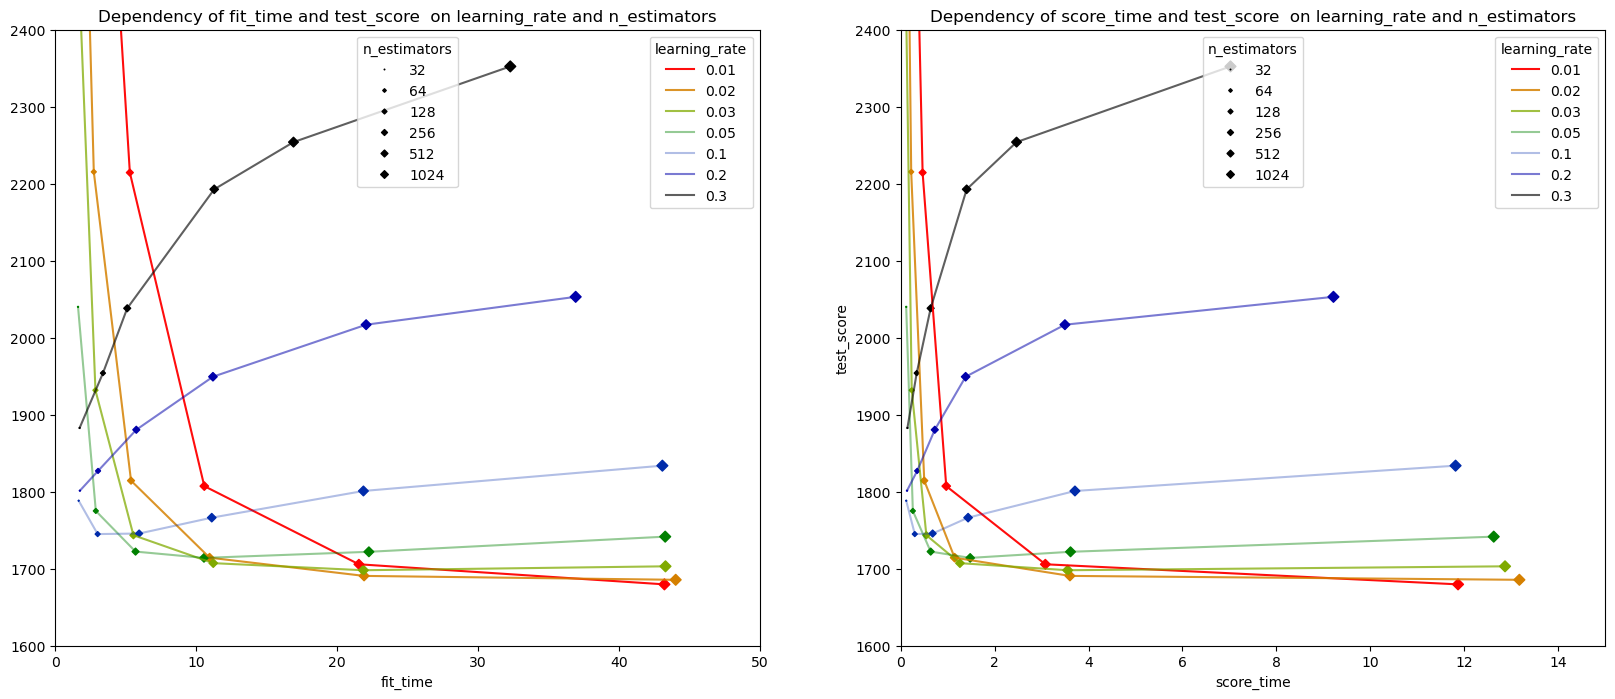

In [26]:
lgbm_figure(gbm_def,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

При скоростях .1 и выше переобучение происходит при небольшом числе оценщиков  и оптимальная метрика не достигается
Скорости 0.01 и ниже видимо позволяют достичь наилучщих метрик, но улучшение ожидается небольшое (<100) в то время как скорости обучения/ предсказания быстро растут
Оптимальны скорости обучения .02-.05

### GOSS

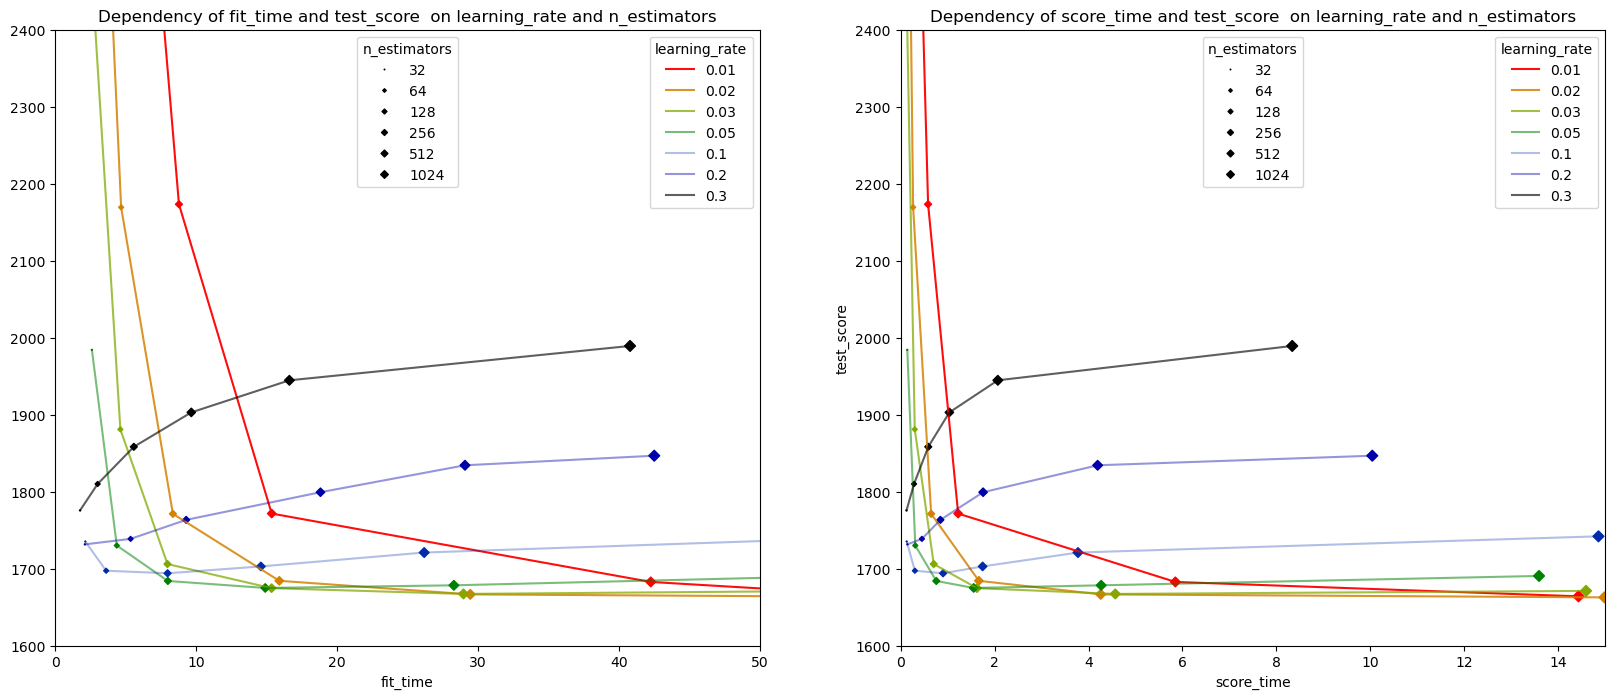

In [27]:
lgbm_figure(gbm_goss,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

Для goss в целом примерно та же картина, но время предсказания несколько меньше
Оптимальными я считаю параметры  learning_rate 0.02-0.05 и n_estimators = 512

### DART

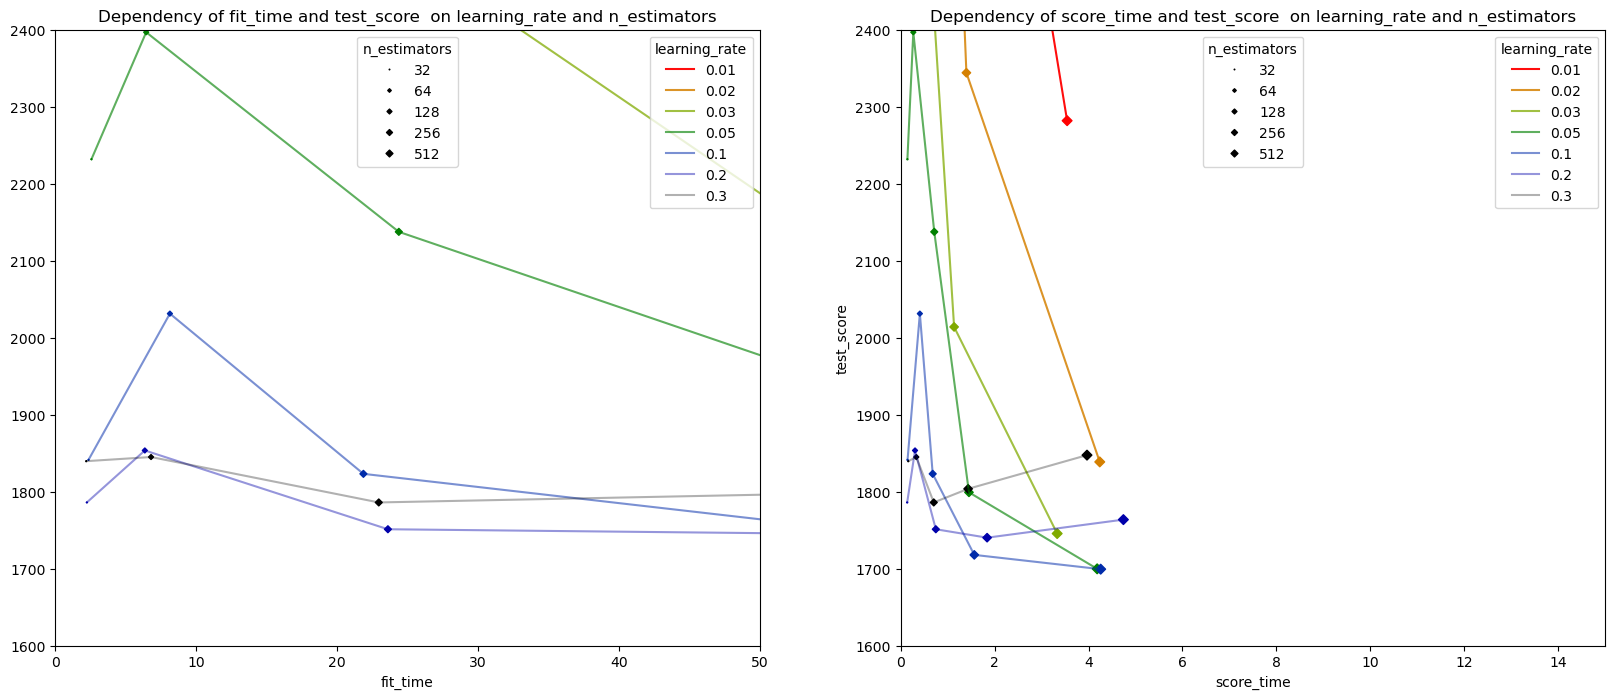

In [28]:
lgbm_figure( gbm_dart,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate' )  

Для darts примерно те же результаты при значительно большем времени обучения.  
Время предсказания внешне выглядит лучше, но только потому, что опущена последняя серия (n_est=1024) из-за очень большого времени обучения 

### Random Forest

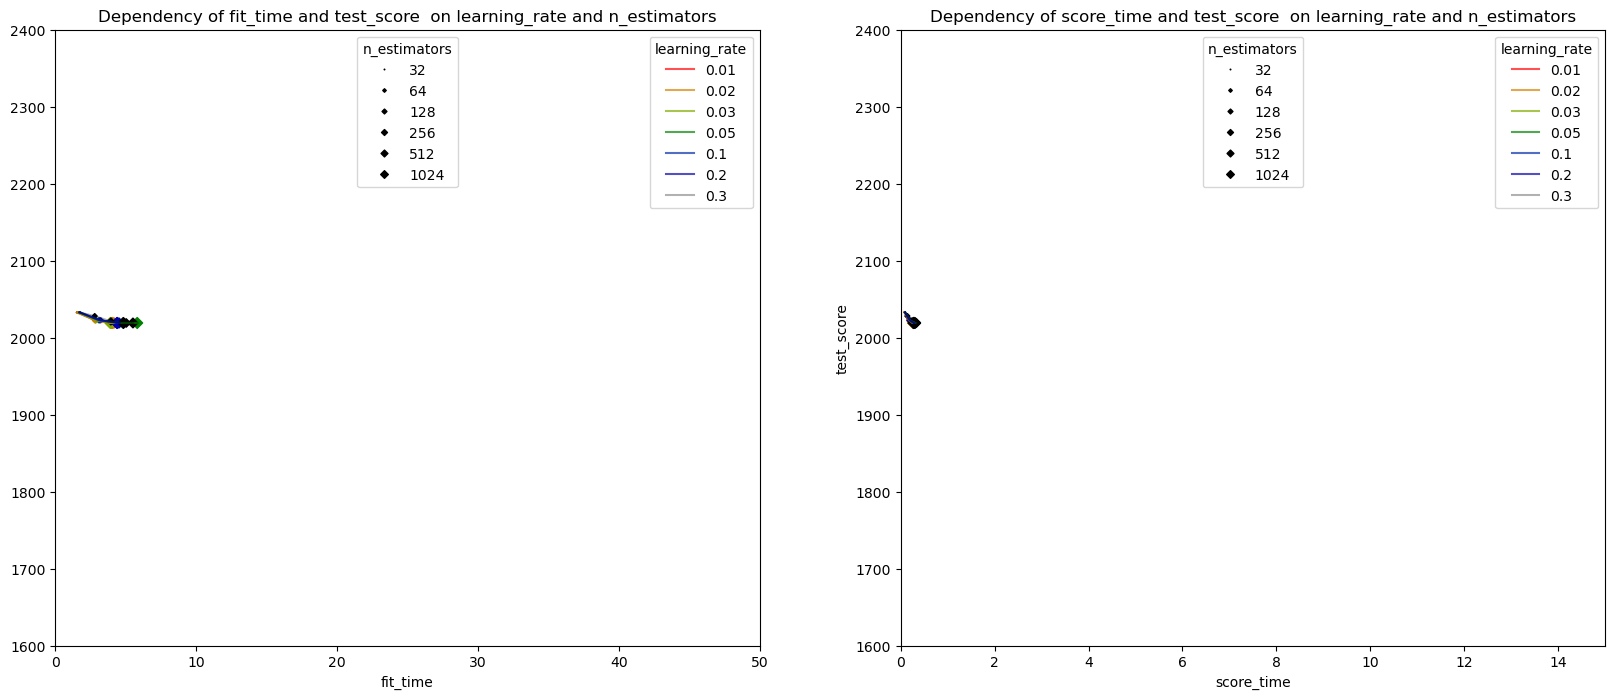

In [29]:
lgbm_figure(gbm_rf,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

При RandomForest результаты получились очень плотные и быстрые, но существенно больше ошибка 

### Структура деревьев

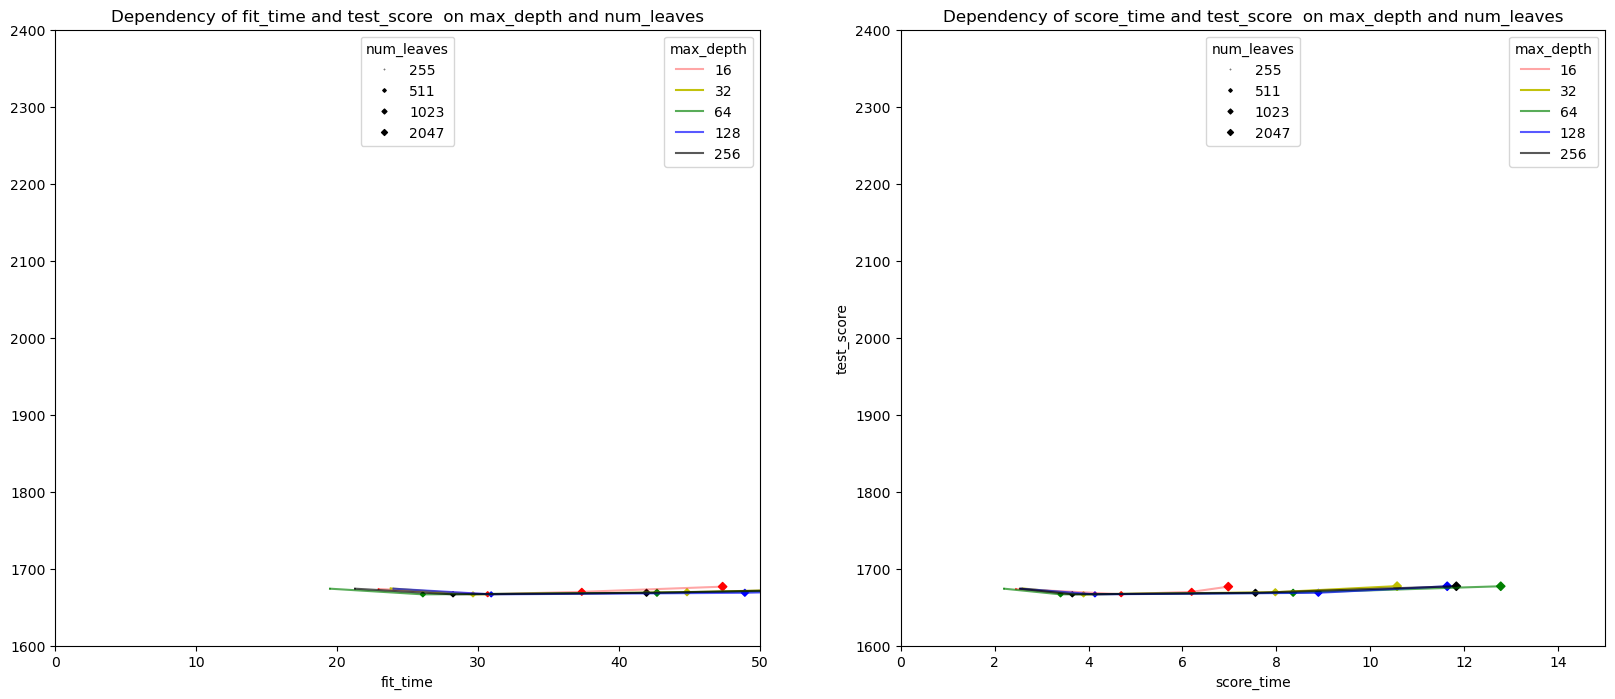

In [31]:
lgbm_figure( gbm_tree,['fit_time','score_time'],['test_score'],along='num_leaves',through='max_depth' )  

Структура дерева практически не влияет на метрику, ну увелечение количества листьев увеличивает время предсказания, по крайней мере для GOSS

### Final test

In [32]:
%%time
start = ti.default_timer()
model = lgb.LGBMRegressor( boosting='goss',objective='l2',learning_rate='.02',n_estimators = 512 
                              , max_depth=64, num_leaves=255)

model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['rmse'],callbacks=cbf)
step_1 = ti.default_timer()
a = model.predict(X_te)
finish = ti.default_timer()


[50]	training's rmse: 2417.02	training's l2: 5.842e+06
[100]	training's rmse: 1829.92	training's l2: 3.34861e+06
[150]	training's rmse: 1659.56	training's l2: 2.75413e+06
[200]	training's rmse: 1586.47	training's l2: 2.51688e+06
[250]	training's rmse: 1542.05	training's l2: 2.37793e+06
[300]	training's rmse: 1508.3	training's l2: 2.27496e+06
[350]	training's rmse: 1480.5	training's l2: 2.19189e+06
[400]	training's rmse: 1456.11	training's l2: 2.12026e+06
[450]	training's rmse: 1434.47	training's l2: 2.05771e+06
[500]	training's rmse: 1414.67	training's l2: 2.00129e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1106.66	valid_0's l2: 1.22469e+06
CPU times: total: 1min 6s
Wall time: 24.5 s


In [33]:
print(f"R2: {round(r2(y_te,a),4)}\tRMSE: {round(rmse(y_te,a))}")
print(f"Время обучения {round(step_1-start,1)} сек \tвремя предсказания {round(finish-step_1,1)} cек")

R2: 0.8661	RMSE: 1647
Время обучения 20.5 сек 	время предсказания 4.0 cек


### Вывод

При обучении модели предсказания цен рекомендуестся использовать алгоритм GOSS  
с гиперпараметрами - 
n_estimators ~ 500
learning_rate  0.02
num_leaves - до 250
При этом ожидаемая ошибка предсказания - до 1700
время обучения - до 25  с, время предсказания до 5 с


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей